In [1]:
import SimpleITK as sitk
import pdb
import os
import numpy as np
import pandas as pd
from skimage import segmentation
import matplotlib.pyplot as plt


In [36]:
# pt = sitk.ReadImage("/home/val/Documents/plc_seg/nii_raw/PatientLC_38__PT.nii.gz")
# ct = sitk.ReadImage("/home/val/Documents/plc_seg/nii_raw/PatientLC_38__CT.nii.gz")
# gtvt = sitk.ReadImage("/home/val/Documents/plc_seg/nii_raw/PatientLC_38__GTV_T__RTSTRUCT__CT.nii.gz")
# gtvl = sitk.ReadImage("/home/val/Documents/plc_seg/nii_raw/PatientLC_38__GTV_L__RTSTRUCT__CT.nii.gz")
patient = 54

pt = sitk.ReadImage(f"/home/val/Documents/plc_seg/nii_raw/PatientLC_{patient}__PT.nii.gz")
ct = sitk.ReadImage(f"/home/val/Documents/plc_seg/nii_raw/PatientLC_{patient}__CT.nii.gz")
gtvt = sitk.ReadImage(f"/home/val/Documents/plc_seg/nii_raw/PatientLC_{patient}__GTV_T__RTSTRUCT__CT.nii.gz")
gtvl = sitk.ReadImage(f"/home/val/Documents/plc_seg/nii_raw/PatientLC_{patient}__GTV_L__RTSTRUCT__CT.nii.gz")

In [37]:
def to_np(image):
    return np.transpose(sitk.GetArrayFromImage(image), (2, 1, 0))

def clip_CT(CT,normalize=True,HU_min=-1350,HU_max=150):
    CT[CT<HU_min]=HU_min
    CT[CT>HU_max]=HU_max
    if normalize:
        CT=(CT-HU_min)/(HU_max-HU_min)
    return CT

def clip_PT(PT,normalize=True, invert=False,SUV_min=0,SUV_max=2.5):
    PT[PT<SUV_min]=SUV_min
    PT[PT>SUV_max]=SUV_max
    if normalize:
        PT=(PT-np.min(PT))/(np.max(PT)-np.min(PT))
    return PT

def normalize_PET(PT):
    return (PT-np.min(PT))/(np.max(PT)-np.min(PT))


In [38]:
resampler = sitk.ResampleImageFilter()
resampler.SetInterpolator(sitk.sitkBSpline)
resampler.SetReferenceImage(ct)
pt = resampler.Execute(pt)
resampler.SetInterpolator(sitk.sitkNearestNeighbor)
gtvt = resampler.Execute(gtvt)
gtvl = resampler.Execute(gtvl)

In [39]:
np_ct = to_np(ct)
np_pt = to_np(pt)

np_gtvt = to_np(gtvt)
np_gtvl = to_np(gtvl)

In [40]:
slicePlot = 227
slicePlot = 190
np_gtvt_slice = np_gtvt[:,:,slicePlot].T
np_gtvl_slice = np_gtvl[:,:,slicePlot].T
# np_gtvt_slice = np.where(np_gtvt_slice<0.5, 0, 1)
# np_gtvl_slice = np.where(np_gtvl_slice<0.5, 0, 1)
np_ct_slice = clip_CT(np_ct[:,:,slicePlot]).T
np_pt_slice = clip_PT(np_pt[:,:,slicePlot], SUV_max=2.5).T

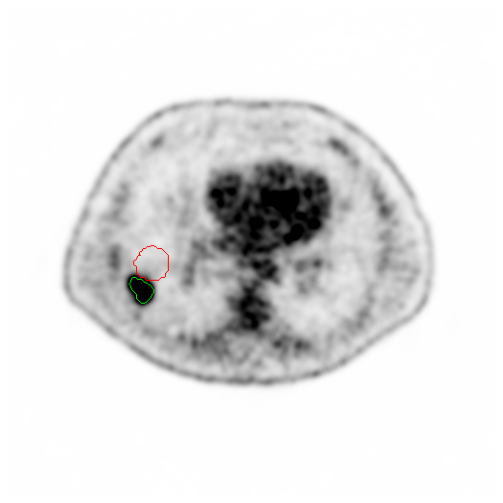

In [41]:
# Draw the contours and plot
np_contour_gtvt = segmentation.clear_border(np_gtvt_slice).astype(np.int32)
np_contour_gtvl = segmentation.clear_border(np_gtvl_slice).astype(np.int32)

np_ct_plot = segmentation.mark_boundaries(np_ct_slice, np_contour_gtvt,color=(0, 1, 0))
np_ct_plot = segmentation.mark_boundaries(np_ct_plot, np_contour_gtvl,color=(1, 0, 0))

np_pt_plot = segmentation.mark_boundaries(1 - np_pt_slice, np_contour_gtvt,color=(0, 1, 0))
np_pt_plot = segmentation.mark_boundaries(np_pt_plot, np_contour_gtvl,color=(1, 0, 0))

plt.figure(figsize=(9,9))
plt.imshow(np_pt_plot)

plt.axis('off')
plt.savefig(f"PatientLC_{patient}_slice_{slicePlot}_CT.png", bbox_inches='tight')